In [1]:
!pip install -q transformers torch pandas tqdm

import pandas as pd
import re
import torch
from transformers import pipeline
from tqdm import tqdm

# Cek apakah GPU terdeteksi
device = 0 if torch.cuda.is_available() else -1
print(f"Status Device: {'Menggunakan GPU (Cepat)' if device == 0 else 'Menggunakan CPU (Lambat, mohon ganti runtime ke GPU)'}")

Status Device: Menggunakan GPU (Cepat)


In [2]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    # 1. Lowercase
    text = text.lower()
    # 2. Hapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # 3. Hapus Mention & Hashtag
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    # 4. Hapus karakter selain huruf dan spasi (angka & tanda baca hilang)
    text = re.sub(r'[^a-z\s]', ' ', text)
    # 5. Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    return text



In [3]:
filename = '/content/drive/MyDrive/Dataset purbaya seri/dataset_tugas_purbaya_vs_srimulyani_lengkap(5000).csv'
try:
    df = pd.read_csv(filename)
    print(f"Data berhasil dimuat: {len(df)} baris.")
except FileNotFoundError:
    print(f"Error: File '{filename}' tidak ditemukan. Mohon upload dulu.")
    # Stop eksekusi jika file tidak ada
    raise

# 2. Lakukan Preprocessing
print("Sedang melakukan cleaning text...")
df['text_clean'] = df['text'].apply(clean_text)
# Hapus baris kosong jika ada
df = df[df['text_clean'] != '']
print("Cleaning selesai.")

# 3. Siapkan Model IndoBERT (Sentiment Analysis)
# Model: w11wo/indonesian-roberta-base-sentiment-classifier
print("Sedang menyiapkan model IndoBERT...")
sentiment_analysis = pipeline(
    "sentiment-analysis",
    model="w11wo/indonesian-roberta-base-sentiment-classifier",
    tokenizer="w11wo/indonesian-roberta-base-sentiment-classifier",
    device=device, # Menggunakan GPU jika tersedia
    truncation=True, # Potong teks jika kepanjangan
    max_length=512
)

# 4. Lakukan Labelling (Prediksi)
print("Sedang melakukan labelling otomatis (bisa memakan waktu beberapa menit)...")

# Kita gunakan batch processing agar lebih efisien memori
results = []
texts = df['text_clean'].tolist()

# Loop dengan progress bar (tqdm)
batch_size = 32
for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i+batch_size]
    # Prediksi batch
    predictions = sentiment_analysis(batch)
    results.extend(predictions)

# 5. Simpan Hasil ke DataFrame
df['prediksi_label_raw'] = [res['label'] for res in results]
df['score_keyakinan'] = [res['score'] for res in results]

# Mapping agar lebih mudah dibaca (opsional)
label_map = {
    'positive': 'Positif',
    'neutral': 'Netral',
    'negative': 'Negatif'
}
df['label_final'] = df['prediksi_label_raw'].map(label_map)


output_filename = 'hasil_labelling_indobert.csv'
df.to_csv(output_filename, index=False)

print("\n" + "="*50)
print(f"PROSES SELESAI! File tersimpan: {output_filename}")
print("Silakan download file tersebut dari menu Files di sebelah kiri.")
print("="*50)

# Tampilkan contoh hasil
print(df[['text_clean', 'label_final']].head(5))

Data berhasil dimuat: 9880 baris.
Sedang melakukan cleaning text...
Cleaning selesai.
Sedang menyiapkan model IndoBERT...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0


Sedang melakukan labelling otomatis (bisa memakan waktu beberapa menit)...


100%|██████████| 307/307 [02:00<00:00,  2.55it/s]


PROSES SELESAI! File tersimpan: hasil_labelling_indobert.csv
Silakan download file tersebut dari menu Files di sebelah kiri.
                                          text_clean label_final
0                   pembantu mu banyak yg rusak paak     Negatif
1  ia pa benar pasl skarang pengusaha suasta smis...     Negatif
2  jangan angguk angguk aja mentri kehutanan liha...     Negatif
3       susah di pecat kalau menterinya ketum parpol     Negatif
4  kerusakan lingkungan tidak akan terjadi kalau ...     Negatif


In [4]:
import pandas as pd

# Load the dataset
df = pd.read_csv('hasil_labelling_indobert.csv')

# Select the specific columns requested
# "label raw" maps to 'prediksi_label_raw' based on previous context
selected_columns = ['text', 'tokoh', 'prediksi_label_raw', 'score_keyakinan', 'label_final']
df_filtered = df[selected_columns]

# Save the filtered dataset
output_filename = 'hasil_labelling_final_filtered.csv'
df_filtered.to_csv(output_filename, index=False)

# Display the first few rows to verify
print(df_filtered.head())

                                                text                 tokoh  \
0                   Pembantu mu banyak yg rusak paak  Purbaya Yudhi Sadewa   
1  Ia pa benar pasl 33 skarang pengusaha suasta s...  Purbaya Yudhi Sadewa   
2  Jangan Angguk angguk aja, Mentri Kehutanan,Lih...  Purbaya Yudhi Sadewa   
3       Susah di pecat kalau menterinya ketum parpol  Purbaya Yudhi Sadewa   
4  Kerusakan lingkungan tidak akan terjadi kalau ...  Purbaya Yudhi Sadewa   

  prediksi_label_raw  score_keyakinan label_final  
0           negative         0.999369     Negatif  
1           negative         0.999472     Negatif  
2           negative         0.999365     Negatif  
3           negative         0.996516     Negatif  
4           negative         0.999033     Negatif  


Tabel Jumlah Sentimen per Tokoh:
label_final            Negatif  Netral  Positif
tokoh                                          
Purbaya Yudhi Sadewa      2646     989     1266
Sri Mulyani Indrawati     3341     965      588


Tabel Persentase Sentimen per Tokoh (%):
label_final            Negatif  Netral  Positif
tokoh                                          
Purbaya Yudhi Sadewa     53.99   20.18    25.83
Sri Mulyani Indrawati    68.27   19.72    12.01


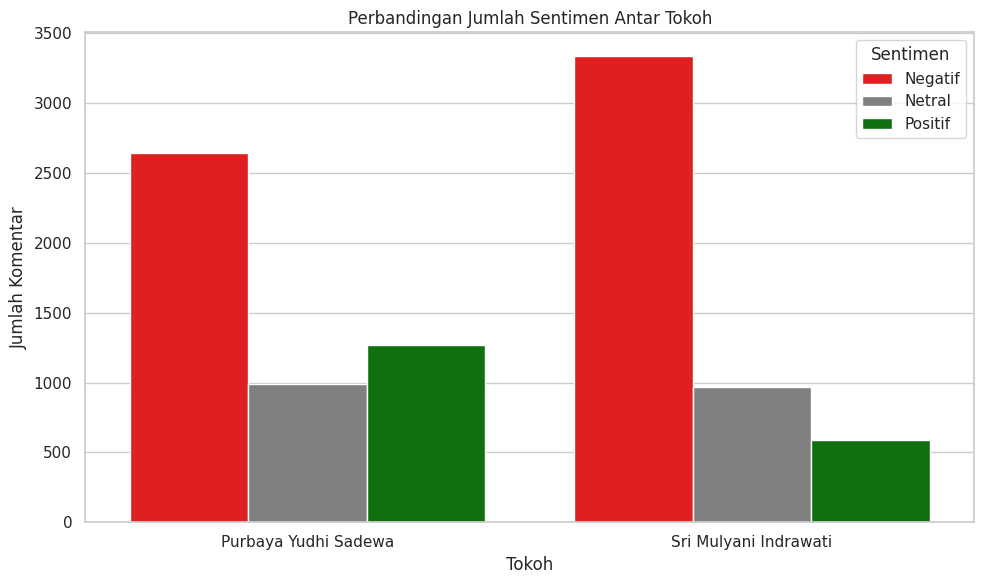

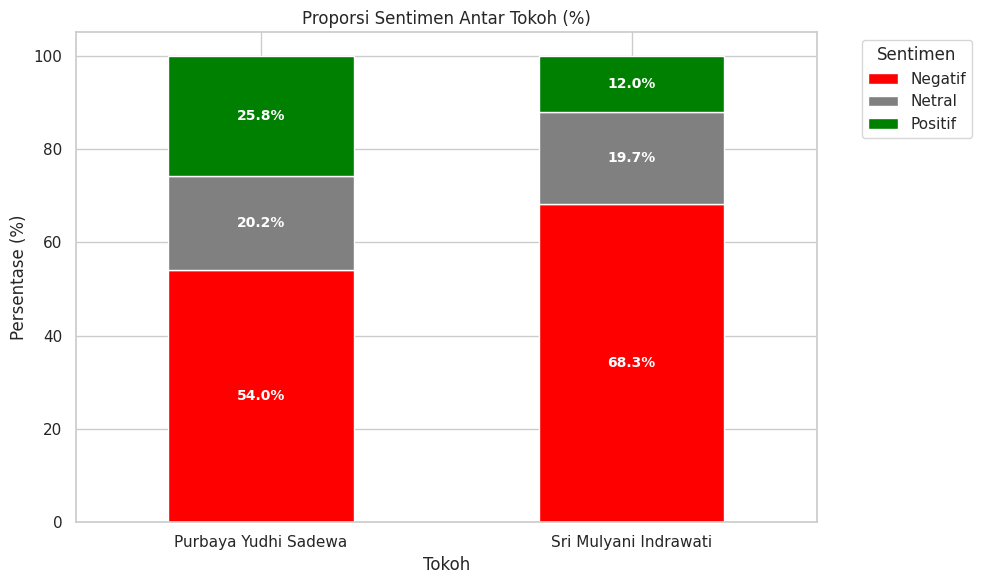

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('hasil_labelling_final_filtered.csv')

# --- EDA & Summary Table ---
# Calculate counts of sentiment per tokoh
sentiment_counts = df.groupby(['tokoh', 'label_final']).size().reset_index(name='count')

# Pivot table for easier reading
sentiment_pivot = sentiment_counts.pivot(index='tokoh', columns='label_final', values='count').fillna(0)

# Calculate percentages per tokoh
sentiment_pct = sentiment_pivot.div(sentiment_pivot.sum(axis=1), axis=0) * 100

print("Tabel Jumlah Sentimen per Tokoh:")
print(sentiment_pivot)
print("\n")
print("Tabel Persentase Sentimen per Tokoh (%):")
print(sentiment_pct.round(2))

# --- Visualization ---

# Set style
sns.set(style="whitegrid")

# 1. Grouped Bar Chart (Counts)
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='tokoh', hue='label_final', palette={'Positif': 'green', 'Netral': 'gray', 'Negatif': 'red'})
plt.title('Perbandingan Jumlah Sentimen Antar Tokoh')
plt.xlabel('Tokoh')
plt.ylabel('Jumlah Komentar')
plt.legend(title='Sentimen')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('sentiment_comparison_counts.png')

# 2. Stacked Bar Chart (Percentages) - for better comparison of proportions
ax = sentiment_pct.plot(kind='bar', stacked=True, color=['red', 'gray', 'green'], figsize=(10, 6))
plt.title('Proporsi Sentimen Antar Tokoh (%)')
plt.xlabel('Tokoh')
plt.ylabel('Persentase (%)')
plt.legend(title='Sentimen', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

# Add percentage labels on the bars
for c in ax.containers:
    ax.bar_label(c, fmt='%.1f%%', label_type='center', color='white', fontsize=10, weight='bold')

plt.tight_layout()
plt.savefig('sentiment_comparison_pct.png')